In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# 读取训练数据集CSV文件，并丢弃'id'列，因为它通常不用于模型训练
df = pd.read_csv("/kaggle/input/playground-series-s4e2/train.csv").drop("id", axis=1)
print("total of missing entries", df.isna().sum())
print(df.info())
# 显示数据集的前5行，以便快速检查数据的格式和前几个值
df.head(5)

total of missing entries Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
#将数据框df中的'NObeyesdad'列分离出来
#x包含了除了'NObeyesdad'列之外的所有列，而y则只包含'NObeyesdad'列。
x = df.drop(["NObeyesdad"], axis=1)
y = df["NObeyesdad"]
x.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
dtype: object

In [4]:
#数据预处理函数，对输入的数据框df进行一系列转换和特征工程操作
def data_engineering(df):
    df = df.copy()
    
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90']
    df['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
    df['Age_Category'] = df['Age_Category'].astype("str")
    
    df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
    
    df["BMI"] = (df["Weight"]/df["Height"]**2).astype("float")
    df["W/H ratio"] = (df["Weight"]/df["Height"]).astype("float")
    
    df["Weight**2"] = (df["Weight"]**2).astype("float")
    df["Age**2"] = (df["Age"]**2).astype("float")
    df["BMI**2"] = (df["BMI"]**2).astype("float")
    
    df["Gender*Age"] = (df["Gender"]*df["Age"]).astype("float")
    df["Gender*Weight"] = (df["Gender"]*df["Weight"]).astype("float")
    df["Gender*BMI"] = (df["Gender"]*df["BMI"]).astype("float")
    df["BMI*Age"] = (df["BMI"]*df["Age"]).astype("float")
    df["(BMI*Age) squared"] = (df["BMI"]**2*df["Age"]**2).astype("float")
    df["(BMI*Age) cubic"] = (df["BMI"]**3*df["Age"]**3).astype("float")
    
    return df

In [5]:
#预处理流程，它包括对分类变量进行独热编码和对数值变量进行标准化。
x = data_engineering(x)
x_cat = x.select_dtypes(include="object").columns
x_num = x.select_dtypes(exclude="object").columns

cat= Pipeline([
    ("cat", OneHotEncoder(handle_unknown="ignore"))
])

num = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("cat", cat, x_cat),
    ("num", num, x_num)
])

In [6]:

params = {
    "objective": "multiclass",          # 模型的目标函数，这里设置为多分类
    "metric": "multi_logloss",          # 评估模型性能的指标
    "verbosity": -1,                    # 日志级别，-1表示不输出任何日志
    "boosting_type": "gbdt",            # 梯度提升树的类型，这里使用GBDT
    "random_state": 42,        # 随机种子，用于结果的可复现性
    "num_class": 7,                      # 数据集中的类别数
    'learning_rate': 0.030962211546832760, # 梯度提升的学习率
    'n_estimators': 500,                # 提升树的数量
    'lambda_l1': 0.009667446568254372,  # L1正则化项
    'lambda_l2': 0.04018641437301800,   # L2正则化项
    'max_depth': 10,                    # 树的最大深度
    'colsample_bytree': 0.40977129346872643,  # 每棵树考虑的特征比例
    'subsample': 0.9535797422450176,   # 每次提升迭代考虑的样本比例
    'min_child_samples': 26             # 叶子节点所需的最小样本数
}
#构建了一个Pipeline，包含预处理步骤preprocessor和LightGBM分类器LGBMClassifier
#参数通过**params传递
model = Pipeline([
    ("pre", preprocessor),
    #("lgbmc", LGBMClassifier(max_depth=10, min_child_samples=30, verbose=-1))
    ("lgbmc", LGBMClassifier(**params))
])


#数据划分
#定义了要进行网格搜索的参数，包括叶子节点数、最大深度、迭代次数和最小子样本数。
#使用GridSearchCV进行网格搜索，找到最佳的参数组合，并更新模型为最佳估计器。
#使用accuracy_score计算验证集上的准确率，model.best_grid_model(x_val)表示使用最佳参数在验证集上的预测结果。
"""x_train, x_val, y_train, y_val = train_test_split(x,y, train_size=0.3, random_state=42)

params = {
    'lgbmc__num_leaves': [31, 50, 70],
    'lgbmc__max_depth': [-1, 10, 20, 30],
    #'learning_rate': [0.1, 0.05, 0.01],
    'lgbmc__n_estimators': [100, 200],
    'lgbmc__min_child_samples': [20, 30, 40],
    #'subsample': [0.6, 0.8, 1.0],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    #'reg_alpha': [0, 0.1, 0.5],
    #'reg_lambda': [0, 0.1, 0.5]
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=0).fit(x_train, y_train)
model = grid.best_estimator_

print(accuracy_score(y_val, model.best_grid_model(x_val)) )"""

"x_train, x_val, y_train, y_val = train_test_split(x,y, train_size=0.3, random_state=42)\n\nparams = {\n    'lgbmc__num_leaves': [31, 50, 70],\n    'lgbmc__max_depth': [-1, 10, 20, 30],\n    #'learning_rate': [0.1, 0.05, 0.01],\n    'lgbmc__n_estimators': [100, 200],\n    'lgbmc__min_child_samples': [20, 30, 40],\n    #'subsample': [0.6, 0.8, 1.0],\n    #'colsample_bytree': [0.6, 0.8, 1.0],\n    #'reg_alpha': [0, 0.1, 0.5],\n    #'reg_lambda': [0, 0.1, 0.5]\n}\n\ngrid = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=0).fit(x_train, y_train)\nmodel = grid.best_estimator_\n\nprint(accuracy_score(y_val, model.best_grid_model(x_val)) )"

In [7]:
"""model = Pipeline([
    ("pre", preprocessor),
    ("lgbmc", LGBMClassifier(**params_best_model))
])"""

'model = Pipeline([\n    ("pre", preprocessor),\n    ("lgbmc", LGBMClassifier(**params_best_model))\n])'

In [8]:
"""model.fit(x_train, y_train)
accuracy_score(y_val, model.predict(x_val)) """

'model.fit(x_train, y_train)\naccuracy_score(y_val, model.predict(x_val)) '

In [9]:
output = pd.read_csv("/kaggle/input/playground-series-s4e2/sample_submission.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")


model.fit(x, y)
test = data_engineering(test)
prediction = model.predict(test)
output["NObeyesdad"] = prediction
output.to_csv("submission.csv", index=False)
output


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


# 使用LightGBM进行分类

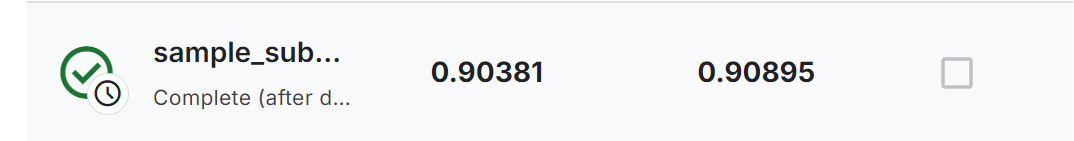

In [10]:
#可视化一个训练好的LightGBM模型的特征重要性。
"""model_fit = model.named_steps['lgbmc']  
importances = model_fit.feature_importances_

feature_names = model.named_steps['pre'].get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df
import seaborn as sns

plt.figure(figsize=(10, 8)) 

# Plot
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', orient='h')

# Adjust layout to increase spacing
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()"""

"model_fit = model.named_steps['lgbmc']  \nimportances = model_fit.feature_importances_\n\nfeature_names = model.named_steps['pre'].get_feature_names_out()\nfeature_importance_df = pd.DataFrame({\n    'Feature': feature_names,\n    'Importance': importances\n}).sort_values(by='Importance', ascending=False)\nfeature_importance_df\nimport seaborn as sns\n\nplt.figure(figsize=(10, 8)) \n\n# Plot\nsns.barplot(data=feature_importance_df, x='Importance', y='Feature', orient='h')\n\n# Adjust layout to increase spacing\nplt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)\n\nplt.xlabel('Importance')\nplt.ylabel('Feature')\nplt.title('Feature Importances')\nplt.show()"